#  Chapter 1 DataCleaning and Exploratory Data Analysis

This first session deals with data cleaning, EDA and builing a simplistic model that can be used for predicting the sale price of houses in Ames, IOWA. Here we try to understand the dataset and get familiar with the methodology for developing an efficient model.

The next session contains a report that contains  the detailed analysis, interpretation, and information for the models. We will do a cross-validation and data splitting where the original data set is split into two data sets: the training set and the validation set. 



## The Data
There are two data sets included in the data folder: `Ames_Housing_Price_Data.csv` and `Ames_Real_Estate_Data.csv`.

The `Ames_Housing_Price_Data.csv` set contains $81$ data columns, including the key feature **SalePrice** which will be used as the target of the predictive/descriptive modeling. **PID** refers to the land parcel ID, which can merged on the *MapRefNo* column of the **Ames Accessor Data** (`Ames_Real_Estate_Data.csv`) to find the property address. Using a free service, such as **geopy**, we can find the long-lat coordinates of the houses.

The columns of the data are mostly attributes associated with the land and the houses. There are size related attributes, quality and condition attributes, house attachment attributes, etc.

To establish a foundation for your team's data analytics, we offer some insights on the house sizes vs. prices.

## Outliers

The instructors' notes state:

> **Five observations** that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true **outliers** (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would **recommend removing any houses with more than
3700 square feet** from the data set (which eliminates these five unusual observations)
before assigning it to students.

To apply a more "rigorous" approach, outlier detection is conducted with a so-called Isolation Forest.

In [1]:
# Import the datasets and the libraries
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statistics as stats
realEstate = pd.read_csv("Ames_Real_Estate_Data.csv")
realEstate = realEstate[['MapRefNo','Prop_Addr','MA_Zip1']]
geocode_data =pd.read_csv("geocode_data.csv")

#Linear Models
from sklearn.linear_model import Lasso, ElasticNet


#Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge


#Gradient Boosting Machines
from sklearn.ensemble import GradientBoostingRegressor

#Random Forest
from sklearn.ensemble import RandomForestRegressor

#Support Vector Machines
from sklearn import svm

#Linear Regression
from sklearn import linear_model

#Make Pipeline
from sklearn.pipeline import make_pipeline

#Robust Scaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split, KFold, cross_val_score


housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)
housing = housing[housing.GrLivArea<3700]
from scipy import stats
housing.head()

/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_54860/4081282890.py:14: DtypeWarning: Columns (36,40,81,87) have mixed types. Specify dtype option on import or set low_memory=False.
  realEstate = pd.read_csv("Ames_Real_Estate_Data.csv")


,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
2,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
3,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
4,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
5,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


In [2]:
housing["Street"].value_counts()

Pave    2567
Grvl      10
Name: Street, dtype: int64

In [3]:
housing.isna().sum()

SalePrice        0
PID              0
GrLivArea        0
MSSubClass       0
MSZoning         0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 81, dtype: int64

In [4]:
housing.Condition1

1      Norm
2      Norm
3      Norm
4      Norm
5      Norm
       ... 
759    Norm
760    Norm
761    Norm
762    Norm
763    Norm
Name: Condition1, Length: 2577, dtype: object

In [5]:
geocode_data.head()

,Unnamed: 0,PID,lat,long,dist,income,gcode
0,1971,535180070,42.042894,-93.612641,3.326988,52375.0,"210, 21st Street, Broadmoor, Ames, Story Count..."
1,1357,908102040,42.020564,-93.678868,2.760245,33311.0,"234, South Dakota Avenue, Ames, Story County, ..."
2,357,906380170,42.024622,-93.691352,3.713174,60833.0,"5327, Durant Street, Sunset Ridge, Ames, Story..."
3,65,909250060,42.019084,-93.646893,0.847709,20878.0,"2320, Knapp Street, Union Drive, Ames, Story C..."
4,1094,534276180,42.042544,-93.621391,2.721892,61991.0,"2027, Ferndale Avenue, Melrose Park, Ames, Sto..."


In [6]:
housing = pd.merge(housing, geocode_data.iloc[:,1:6], how='left', left_on='PID', right_on ="PID")
housing.isna().sum()

SalePrice          0
PID                0
GrLivArea          0
MSSubClass         0
MSZoning           0
                ... 
SaleCondition      0
lat               99
long              99
dist              99
income           184
Length: 85, dtype: int64

In [7]:

qual_related = housing.filter(regex='Qual$|Cond$').fillna("TA")
qual_related

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,KitchenQual,GarageQual,GarageCond
0,6,6,TA,TA,TA,TA,TA,TA,TA
1,5,5,Gd,TA,Gd,TA,Gd,TA,TA
2,5,9,Gd,TA,TA,TA,Gd,TA,Po
3,4,8,Gd,Gd,Fa,TA,TA,TA,TA
4,8,6,Gd,TA,Gd,TA,Gd,TA,TA
...,...,...,...,...,...,...,...,...,...
2572,6,6,TA,TA,TA,TA,Fa,Fa,Po
2573,3,5,TA,TA,TA,TA,TA,TA,TA
2574,5,6,TA,TA,TA,TA,TA,TA,TA
2575,7,5,Gd,TA,Gd,TA,Gd,TA,TA


In [8]:
qual_related.GarageCond.value_counts()

TA    2482
Fa      67
Gd      14
Po      11
Ex       3
Name: GarageCond, dtype: int64

In [9]:
# Fill missing values vith TA
qual_related.fillna("TA", inplace=True)
def Rating(t):
    if t =="Ex": return  7
    elif t == "Gd": return 5
    elif t == "TA": return 3
    elif t == "Fa": return 2.5
    elif t == "Po": return 1
    else: return 0
for ele in qual_related.iloc[:,2:]:
    
    housing[ele]=qual_related[ele].map(Rating)
    qual_related[ele]=housing[ele]
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lat,long,dist,income
0,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,NaN,0,3,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN
1,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,NaN,0,2,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0
2,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,NaN,0,11,2007,WD,Normal,NaN,NaN,NaN,NaN
3,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,NaN,0,5,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0
4,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,NaN,0,11,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,121000,903205040,952,30,RL,NaN,8854,Pave,NaN,Reg,...,NaN,0,5,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0
2573,139600,905402060,1733,20,RL,NaN,13680,Pave,NaN,IR1,...,NaN,0,6,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0
2574,145000,909275030,2002,90,RH,82.0,6270,Pave,NaN,Reg,...,NaN,0,8,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0
2575,217500,907192040,1842,60,RL,NaN,8826,Pave,NaN,Reg,...,NaN,0,7,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0


In [10]:
housing.isna().sum()

SalePrice          0
PID                0
GrLivArea          0
MSSubClass         0
MSZoning           0
                ... 
SaleCondition      0
lat               99
long              99
dist              99
income           184
Length: 85, dtype: int64

In [11]:
qual_related

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,KitchenQual,GarageQual,GarageCond
0,6,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,5,5,5.0,3.0,5.0,3.0,5.0,3.0,3.0
2,5,9,5.0,3.0,3.0,3.0,5.0,3.0,1.0
3,4,8,5.0,5.0,2.5,3.0,3.0,3.0,3.0
4,8,6,5.0,3.0,5.0,3.0,5.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...
2572,6,6,3.0,3.0,3.0,3.0,2.5,2.5,1.0
2573,3,5,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2574,5,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2575,7,5,5.0,3.0,5.0,3.0,5.0,3.0,3.0


### UpSampling the Street labels

In [12]:
housing.Street.value_counts()
def Ratio(t):
    if t == 'Pave': return 1.0
   
    else: return 180.0
# the returned values must be integers   
ratios = housing['Street'].map(Ratio)
index_repeat = housing.index.repeat(ratios)
index_repeat = pd.Series(index_repeat, name='repeat')
index_repeat.shape

(4367,)

In [13]:
housing["Street"].value_counts()
housing["Street"] =housing["Street"].apply(lambda x: 1 if x=="Pave" else 0)
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lat,long,dist,income
0,126000,909176150,856,30,RL,NaN,7890,1,NaN,Reg,...,NaN,0,3,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN
1,139500,905476230,1049,120,RL,42.0,4235,1,NaN,Reg,...,NaN,0,2,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0
2,124900,911128020,1001,30,C (all),60.0,6060,1,NaN,Reg,...,NaN,0,11,2007,WD,Normal,NaN,NaN,NaN,NaN
3,114000,535377150,1039,70,RL,80.0,8146,1,NaN,Reg,...,NaN,0,5,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0
4,227000,534177230,1665,60,RL,70.0,8400,1,NaN,Reg,...,NaN,0,11,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,121000,903205040,952,30,RL,NaN,8854,1,NaN,Reg,...,NaN,0,5,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0
2573,139600,905402060,1733,20,RL,NaN,13680,1,NaN,IR1,...,NaN,0,6,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0
2574,145000,909275030,2002,90,RH,82.0,6270,1,NaN,Reg,...,NaN,0,8,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0
2575,217500,907192040,1842,60,RL,NaN,8826,1,NaN,Reg,...,NaN,0,7,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0


housing = housing.loc[index_repeat].Street.value_counts()

In [14]:
housing = pd.merge(index_repeat, housing, how='left', left_on = "repeat", right_on=housing.index)

In [15]:
housing

,repeat,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lat,long,dist,income
0,0,126000,909176150,856,30,RL,NaN,7890,1,NaN,...,NaN,0,3,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN
1,1,139500,905476230,1049,120,RL,42.0,4235,1,NaN,...,NaN,0,2,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0
2,2,124900,911128020,1001,30,C (all),60.0,6060,1,NaN,...,NaN,0,11,2007,WD,Normal,NaN,NaN,NaN,NaN
3,3,114000,535377150,1039,70,RL,80.0,8146,1,NaN,...,NaN,0,5,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0
4,4,227000,534177230,1665,60,RL,70.0,8400,1,NaN,...,NaN,0,11,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,2572,121000,903205040,952,30,RL,NaN,8854,1,NaN,...,NaN,0,5,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0
4363,2573,139600,905402060,1733,20,RL,NaN,13680,1,NaN,...,NaN,0,6,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0
4364,2574,145000,909275030,2002,90,RH,82.0,6270,1,NaN,...,NaN,0,8,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0
4365,2575,217500,907192040,1842,60,RL,NaN,8826,1,NaN,...,NaN,0,7,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0


In [16]:
housing.isna().sum()

repeat              0
SalePrice           0
PID                 0
GrLivArea           0
MSSubClass          0
                 ... 
SaleCondition       0
lat               994
long              994
dist              994
income           1258
Length: 86, dtype: int64

In [17]:
def Ratio2(t):
    if t =="Normal": return  1.0
    elif t == "Partial": return 4
    elif t == "Alloca": return 5
    elif t == "Abnormal": return 6
    elif t == "Family": return 12
    else: return 100

ratios = housing['SaleCondition'].map(Ratio2)
index_repeat = housing.index.repeat(ratios)
index_repeat = pd.Series(index_repeat, name='repeat1')
index_repeat
housing = pd.merge(index_repeat, housing, how='left', left_on = "repeat1", right_on=housing.index)
housing.shape

(11766, 87)

In [18]:
def fnd(t):
    if t =="PConc": return  1
    elif t == "CBlock": return 0
    else: return -0.5

housing['Foundation'] = housing['Foundation'].map(fnd)
    
    
       

In [19]:
housing["GarageType"].value_counts()

Attchd     5307
Detchd     3770
2Types      398
BuiltIn     396
Basment     228
CarPort     188
Name: GarageType, dtype: int64

In [20]:
def grg(t):
    if t ==("Attchd" or "Builtin") : return  1
    else: return 0
    -0.5

housing['GarageType'] = housing['GarageType'].map(grg)

In [21]:
housing.groupby("SaleType").mean()

,repeat1,repeat,SalePrice,PID,GrLivArea,MSSubClass,LotFrontage,LotArea,Street,OverallQual,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,lat,long,dist,income
SaleType,,,,,,,,,,,,,,,,,,,,,
COD,723.198420,583.644425,133751.457419,7.029464e+08,1468.127305,69.165935,65.517442,9590.268657,1.000000,5.447761,...,0.000000,22.034241,0.000000,0.438982,7.138718,2007.908692,42.034273,-93.636307,2.705023,46716.479100
CWD,628.627273,557.027273,314872.272727,5.502223e+08,1683.554545,113.909091,51.203704,5614.209091,1.000000,8.754545,...,0.000000,0.000000,0.000000,0.000000,1.563636,2007.909091,42.045708,-93.646170,2.239271,79895.027273
Con,893.750000,692.375000,255790.000000,8.116064e+08,1451.625000,58.750000,51.875000,13737.625000,1.000000,6.750000,...,0.000000,0.000000,0.000000,0.000000,3.625000,2009.125000,42.030754,-93.656118,2.010427,40205.125000
ConLD,2274.236025,1427.414079,75279.113872,9.012821e+08,886.140787,30.496894,109.457380,16498.443064,0.254658,2.956522,...,0.000000,0.354037,0.000000,208.695652,5.217391,2008.380952,42.031210,-93.627442,2.050413,40188.122951
ConLI,933.658120,730.179487,129401.282051,5.733757e+08,1700.222222,83.846154,69.318966,8799.717949,1.000000,5.188034,...,0.000000,0.000000,0.000000,6.837607,10.632479,2006.444444,42.036031,-93.667924,2.741395,58405.034483
ConLw,832.421053,653.421053,103447.368421,8.842071e+08,1265.736842,53.421053,56.894737,8234.894737,1.000000,4.947368,...,0.000000,0.000000,0.000000,0.000000,7.789474,2007.473684,42.028279,-93.631819,1.979938,37890.555556
New,597.679487,478.346154,288989.820513,5.773191e+08,1766.717949,50.256410,75.025974,10929.230769,1.000000,7.717949,...,5.858974,11.243590,0.000000,0.000000,6.897436,2007.051282,42.051644,-93.650726,3.480394,77854.160000
Oth,679.441860,501.036545,111325.913621,7.890204e+08,1230.102990,43.289037,76.285714,10926.259136,1.000000,4.996678,...,0.000000,0.000000,0.000000,0.000000,3.691030,2009.000000,42.016606,-93.635500,3.602751,51463.880399
VWD,816.000000,637.000000,137000.000000,9.052262e+08,1176.000000,20.000000,85.000000,13770.000000,1.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,10.000000,2007.000000,42.033870,-93.661950,1.505130,60833.000000


In [22]:
housing["MasVnrType"] =np.where(housing["MasVnrType"]==("BrkCmn" or "Stone"),1,0)

In [23]:
housing["RoofStyle"] = np.where(housing["RoofStyle"] == "Hip",1,0)

In [24]:
# Checking unique PID #s
uni = housing.PID.unique()
uni.shape

(2576,)

In [25]:
housing.isna().sum()

repeat1             0
repeat              0
SalePrice           0
PID                 0
GrLivArea           0
                 ... 
SaleCondition       0
lat              1693
long             1693
dist             1693
income           2173
Length: 87, dtype: int64

In [26]:
housing.shape

(11766, 87)

<AxesSubplot:title={'center':'SalePrice'}, xlabel='Neighborhood'>

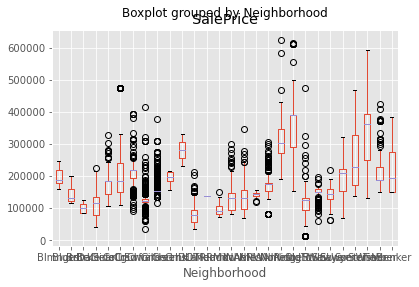

In [27]:
# How does the price vary by neighbourhood
plt.style.use('ggplot')



housing.boxplot(column ='SalePrice', by = 'Neighborhood')

In [28]:
# merging 2.5Unf values into 1Story
housing['HouseStyle'].replace('2.5Unf', '1Story', inplace=True)
# merging 2.5Fin to 2Story
housing['HouseStyle'].replace('2.5Fin', '2Story', inplace=True)
# merging 1.5Unf values into 1.5Fin
housing['HouseStyle'].replace('1.5Unf', '1.5Fin', inplace=True)

In [29]:
housing.HouseStyle.value_counts()

1Story    6726
2Story    2480
1.5Fin    1684
SFoyer     461
SLvl       415
Name: HouseStyle, dtype: int64

### Encoding and Dummyfication

In [30]:
# get the averge price by neighborhood
dummy = housing.groupby("Neighborhood")[["SalePrice"]].mean()
dummy.rename(columns = {"SalePrice":"Price_by_hood"}, inplace =True)
dummy

,Price_by_hood
Neighborhood,
Blmngtn,196863.000000
Blueste,143590.000000
BrDale,99106.512605
BrkSide,113938.566351
ClearCr,173232.067227
CollgCr,237472.640794
Crawfor,210245.493088
Edwards,129455.209790
Gilbert,162418.936561


In [31]:

housing = pd.merge(housing, dummy, how='left', on=['Neighborhood', 'Neighborhood'])
housing

,repeat1,repeat,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lat,long,dist,income,Price_by_hood
0,0,0,126000,909176150,856,30,RL,NaN,7890,1,...,0,3,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN,151017.291667
1,1,1,139500,905476230,1049,120,RL,42.0,4235,1,...,0,2,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0,129455.209790
2,2,2,124900,911128020,1001,30,C (all),60.0,6060,1,...,0,11,2007,WD,Normal,NaN,NaN,NaN,NaN,77290.456957
3,3,3,114000,535377150,1039,70,RL,80.0,8146,1,...,0,5,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0,107889.263043
4,4,4,227000,534177230,1665,60,RL,70.0,8400,1,...,0,11,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0,171828.487859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11761,4362,2572,121000,903205040,952,30,RL,NaN,8854,1,...,0,5,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0,113938.566351
11762,4363,2573,139600,905402060,1733,20,RL,NaN,13680,1,...,0,6,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0,129455.209790
11763,4364,2574,145000,909275030,2002,90,RH,82.0,6270,1,...,0,8,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0,210245.493088
11764,4365,2575,217500,907192040,1842,60,RL,NaN,8826,1,...,0,7,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0,237472.640794


In [32]:
housing.isna().sum()

repeat1             0
repeat              0
SalePrice           0
PID                 0
GrLivArea           0
                 ... 
lat              1693
long             1693
dist             1693
income           2173
Price_by_hood       0
Length: 88, dtype: int64

In [33]:
housing

,repeat1,repeat,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lat,long,dist,income,Price_by_hood
0,0,0,126000,909176150,856,30,RL,NaN,7890,1,...,0,3,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN,151017.291667
1,1,1,139500,905476230,1049,120,RL,42.0,4235,1,...,0,2,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0,129455.209790
2,2,2,124900,911128020,1001,30,C (all),60.0,6060,1,...,0,11,2007,WD,Normal,NaN,NaN,NaN,NaN,77290.456957
3,3,3,114000,535377150,1039,70,RL,80.0,8146,1,...,0,5,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0,107889.263043
4,4,4,227000,534177230,1665,60,RL,70.0,8400,1,...,0,11,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0,171828.487859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11761,4362,2572,121000,903205040,952,30,RL,NaN,8854,1,...,0,5,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0,113938.566351
11762,4363,2573,139600,905402060,1733,20,RL,NaN,13680,1,...,0,6,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0,129455.209790
11763,4364,2574,145000,909275030,2002,90,RH,82.0,6270,1,...,0,8,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0,210245.493088
11764,4365,2575,217500,907192040,1842,60,RL,NaN,8826,1,...,0,7,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0,237472.640794


In [34]:
housing.SaleType.value_counts()

WD       9276
COD      1139
ConLD     483
New       312
Oth       301
ConLI     117
CWD       110
ConLw      19
Con         8
VWD         1
Name: SaleType, dtype: int64

In [35]:
housing.columns

Index(['repeat1', 'repeat', 'SalePrice', 'PID', 'GrLivArea', 'MSSubClass',
       'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual

In [36]:

# We trim the outliers from the list
#housing = housing
#leng = len(housing)
#print(leng)
#housing["Gradient"] = (housing.SalePrice-15000)/(housing.GrLivArea)

#housing=housing.sort_values(by="Gradient")[(housing.sort_values(by="Gradient")["Gradient"]>30) & (housing.sort_values(by="Gradient")["Gradient"]<220)]
#housing["Gradient2"] = (housing.SalePrice)/(housing.GrLivArea-1600.01) 
#housing=housing.sort_values(by="Gradient2")[ (housing.sort_values(by="Gradient2")["Gradient2"]>250)|(housing.sort_values(by="Gradient2")["Gradient2"]<0)]
#housing["Gradient3"] = (housing.SalePrice -100000)/(housing.TotalBsmtSF +1) 
#housing=housing.sort_values(by="Gradient3")[ (housing.sort_values(by="Gradient3")["Gradient3"]<200)]
#housing["Gradient4"] = (housing.SalePrice)/(housing.TotalBsmtSF-1200.01) 
#housing=housing.sort_values(by="Gradient4")[ (housing.sort_values(by="Gradient4")["Gradient4"]>300000/1300)|(housing.sort_values(by="Gradient4")["Gradient4"]<0)]

#housing
#leng2 = len(housing)
#outlier_pct = 100*(leng-leng2)/leng
#outlier_pct


In [37]:
housing.PavedDrive = np.where(housing.PavedDrive=="N", 0,1)
housing.CentralAir = np.where(housing.CentralAir=="N", 0,1)

### Fixing Missing Values

In [38]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_pct = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_pct], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns.sort_values(by= "Missing Values")[mis_val_table_ren_columns["Missing Values"]>10] 
    

/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_54860/2694707503.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mis_val_table_ren_columns.sort_values(by= "Missing Values")[mis_val_table_ren_columns["Missing Values"]>10]


<AxesSubplot:>

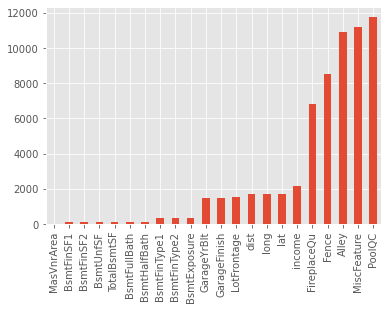

In [39]:
missing_values_table(housing)["Missing Values"].plot.bar()

In [40]:
housing=housing.drop(["MiscFeature"], axis=1)

In [41]:
housing[housing.columns[housing.isnull().any()]]

,LotFrontage,Alley,MasVnrArea,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PoolQC,Fence,lat,long,dist,income
0,NaN,NaN,0.0,No,Rec,238.0,Unf,0.0,618.0,856.0,...,1939.0,Unf,2.0,399.0,NaN,NaN,42.018564,-93.651619,0.998896,NaN
1,42.0,NaN,149.0,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,...,1984.0,Fin,1.0,266.0,NaN,NaN,42.024855,-93.663671,1.433537,21333.0
2,60.0,NaN,0.0,No,ALQ,737.0,Unf,0.0,100.0,837.0,...,1930.0,Unf,1.0,216.0,NaN,NaN,NaN,NaN,NaN,NaN
3,80.0,NaN,0.0,No,Unf,0.0,Unf,0.0,405.0,405.0,...,1940.0,Unf,1.0,281.0,NaN,NaN,42.037391,-93.612207,3.072689,52375.0
4,70.0,NaN,0.0,No,GLQ,643.0,Unf,0.0,167.0,810.0,...,2001.0,Fin,2.0,528.0,NaN,NaN,42.044554,-93.631818,2.326978,61991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11761,NaN,NaN,0.0,No,Unf,0.0,Unf,0.0,952.0,952.0,...,1916.0,Unf,1.0,192.0,NaN,NaN,42.032102,-93.626373,1.768156,37028.0
11762,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,...,1955.0,Unf,2.0,452.0,NaN,NaN,42.027669,-93.666138,1.626168,21333.0
11763,82.0,NaN,0.0,No,BLQ,284.0,Unf,0.0,717.0,1001.0,...,1949.0,Unf,3.0,871.0,NaN,NaN,42.020129,-93.643832,0.763415,20878.0
11764,NaN,NaN,144.0,No,GLQ,841.0,Unf,0.0,144.0,985.0,...,2000.0,Fin,2.0,486.0,NaN,NaN,42.016802,-93.689748,3.739425,33311.0


### "Proximity to various Conditions"

The columns *Condition 1* and *Condition 2* have the same realizations and can be regarded as "tags" given to a house indicating the nearby presence of a) a major street, b) a railroad, or c) a park.

The default tag "Norm" (implying no "condition") is given to 86% of the houses 

In [42]:
housing["Condition1"] = housing["Condition1"].apply(lambda x: 0 if x =="Norm" else 1)
housing["Condition2"] = housing["Condition2"].apply(lambda x: 0 if x =="Norm" else 1)


In [43]:
#changing the NA values which aren't NAs to different values to work better with the data set
medl = housing.LotFrontage.median()
medm = housing.MasVnrArea.median()
housing.Alley = housing.Alley.fillna("No Alley Access")
housing.LotFrontage = housing.LotFrontage.fillna(medl)
housing.MasVnrArea = housing.MasVnrArea.fillna(medm)
housing.MasVnrType = housing.MasVnrType.fillna('None')
housing.BsmtQual = housing.BsmtQual.fillna("No Basement")

In [44]:

housing.PoolQC = housing.PoolQC.fillna(0)
housing.PoolQC=np.where(housing.PoolQC==0, 0,1)

In [45]:
# Fill the NA with the right values
housing.BsmtCond = housing.BsmtCond.fillna("No Basement")
housing.BsmtExposure = housing.BsmtExposure.fillna("No Basement")
housing.BsmtFinType1 = housing.BsmtFinType1.fillna("No Basement")
housing.BsmtFinType2 = housing.BsmtFinType2.fillna("No Basement")
housing.FireplaceQu = housing.FireplaceQu.fillna("No Fireplace")
housing.GarageType = housing.GarageType.fillna("No Garage")
housing.GarageFinish = housing.GarageFinish.fillna("No Garage")
housing.GarageQual = housing.GarageQual.fillna("No Garage")
housing.GarageCond = housing.GarageCond.fillna("No Garage")
housing.Fence = housing.Fence.fillna("No Fence")
housing.Electrical = housing.Electrical.fillna("None")


In [46]:
for i in range(len(housing["Exterior1st"])):
    if housing["Exterior1st"][i] in  ['PreCast',  'ImStucc', 'CemntBd']:
        housing["Exterior1st"][i] =1
    elif housing["Exterior1st"][i] in ['AsphShn', 'AsbShng', 'CBlock']:
        housing["Exterior1st"][i] =-1
    else: 
        housing["Exterior1st"][i] =0
for i in range(len(housing["Exterior2nd"])):
    if housing["Exterior1st"][i] in  ['PreCast',  'ImStucc', 'CemntBd']:
        housing["Exterior1st"][i] =1
    elif housing["Exterior1st"][i] in ['AsphShn', 'AsbShng', 'CBlock']:
        housing["Exterior1st"][i] =-1
    else: 
        housing["Exterior1st"][i] =0    


/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_54860/3942834739.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing["Exterior1st"][i] =0
/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_54860/3942834739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing["Exterior1st"][i] =1
/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_54860/3942834739.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [47]:
# Unify the two townhouse types into one.
housing["BldgType"] = housing["BldgType"].apply(
    lambda x: "Twnhs" if x in ("TwnhsE", "TwnhsI") else x
)
# Unify the two kinds of 2-family homes.
housing["BldgType"] = housing["BldgType"].apply(
    lambda x: "2Fam" if x in ("2FmCon", "Duplx") else x
)

In [48]:
#imputing KNN #imputing KNN 

from fancyimpute  import KNN
# calling the KNN class
knn_imputer = KNN()
# imputing the missing value with knn imputer

housing[['LotFrontage','MasVnrArea',"BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","GarageArea","long","lat","dist","income","BsmtFullBath","BsmtHalfBath","GarageCars","GarageYrBlt"]] = knn_imputer.fit_transform(housing[['LotFrontage','MasVnrArea',"BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","GarageArea","long","lat","dist","income","BsmtFullBath","BsmtHalfBath","GarageCars","GarageYrBlt"]])



Imputing row 1/11766 with 1 missing, elapsed time: 15.771
Imputing row 101/11766 with 1 missing, elapsed time: 15.777
Imputing row 201/11766 with 0 missing, elapsed time: 15.779
Imputing row 301/11766 with 0 missing, elapsed time: 15.780
Imputing row 401/11766 with 0 missing, elapsed time: 15.781
Imputing row 501/11766 with 0 missing, elapsed time: 15.781
Imputing row 601/11766 with 0 missing, elapsed time: 15.782
Imputing row 701/11766 with 0 missing, elapsed time: 15.782
Imputing row 801/11766 with 0 missing, elapsed time: 15.782
Imputing row 901/11766 with 5 missing, elapsed time: 15.792
Imputing row 1001/11766 with 0 missing, elapsed time: 15.798
Imputing row 1101/11766 with 0 missing, elapsed time: 15.798
Imputing row 1201/11766 with 0 missing, elapsed time: 15.799
Imputing row 1301/11766 with 0 missing, elapsed time: 15.799
Imputing row 1401/11766 with 0 missing, elapsed time: 15.799
Imputing row 1501/11766 with 0 missing, elapsed time: 15.800
Imputing row 1601/11766 with 0 missi

In [49]:
# We covert the year to age and take the squareroot to normalise the values
housing.YearBuilt = np.sqrt(2010 - housing.YearBuilt)
housing.GarageYrBlt = np.sqrt(2010 - housing.GarageYrBlt)
housing.YrSold = np.sqrt(2010 -housing.YrSold)
housing.YearRemodAdd = np.sqrt(2010 -housing.YearRemodAdd)

In [50]:
housing.YearBuilt

0         8.426150
1         5.099020
2         8.944272
3        10.488088
4         3.000000
           ...    
11761     9.695360
11762     7.416198
11763     7.810250
11764     3.162278
11765     4.123106
Name: YearBuilt, Length: 11766, dtype: float64

In [51]:
# Creation of new column combining full and half bathrooms into one
bathrm = (housing['FullBath'] + housing['BsmtFullBath'] +
(housing['HalfBath']*0.5) + (housing['BsmtHalfBath']*0.5))
housing['bathrm_cnt'] = bathrm

# Creation of new column combining deck/porch-related sq footage into one
patioSF = (housing['WoodDeckSF'] + housing['OpenPorchSF']+ housing['EnclosedPorch'] + 
           housing['3SsnPorch'] + housing['ScreenPorch'])
housing['patioSF'] = patioSF

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


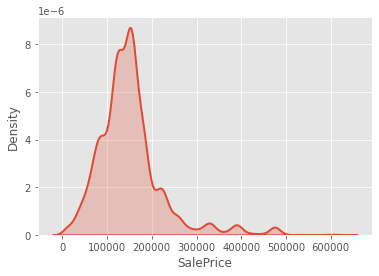

In [52]:
sns.distplot(housing.SalePrice, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

In [53]:
housing["SalePrice"].mean()

150756.3627400986

(array([ 100.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  101.,  100.,    2.,    0.,  101.,  100.,
           5.,  185.,  192.,  105.,  212.,  502.,  247.,  330.,  355.,
         381., 1031., 1013.,  775.,  918., 1627.,  925.,  603.,  261.,
         366.,  320.,  216.,   88.,   62.,  160.,   50.,  137.,   45.,
          18.,  110.,    5.,    6.,   12.]),
 array([ 9.45641889,  9.53420069,  9.61198248,  9.68976427,  9.76754607,
         9.84532786,  9.92310965, 10.00089144, 10.07867324, 10.15645503,
        10.23423682, 10.31201861, 10.38980041, 10.4675822 , 10.54536399,
        10.62314578, 10.70092758, 10.77870937, 10.85649116, 10.93427296,
        11.01205475, 11.08983654, 11.16761833, 11.24540013, 11.32318192,
        11.40096371, 11.4787455 , 11.5565273 , 11.63430909, 11.71209088,
        11.78987268, 11.86765447, 11.94543626, 12.02321805, 12.10099985,
        12.17878164, 12.25656343, 12.33434522, 12.41212702, 12.48990881,
        12.56769

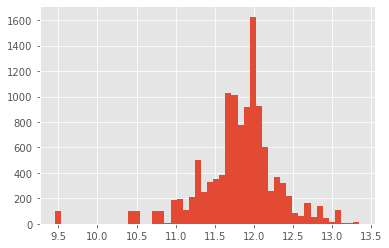

In [54]:
#use the log function to make the data normal
plt.hist(np.log(housing.SalePrice+1), bins = 50)

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


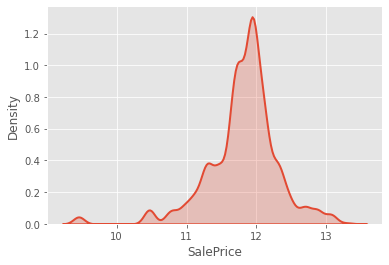

In [55]:
sns.distplot(np.log(housing.SalePrice+1), hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

In [56]:
np.log(housing["SalePrice"]).mean()

11.808187186286181

In [57]:
# Check the different types of foundations
#print(housing.Foundation.value_counts())
#sns.countplot(housing.Foundation)


11766
11766
11766
11766
11766
11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


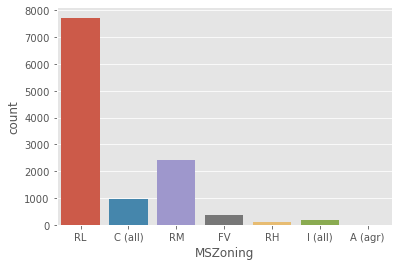

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


11766
11766
11766


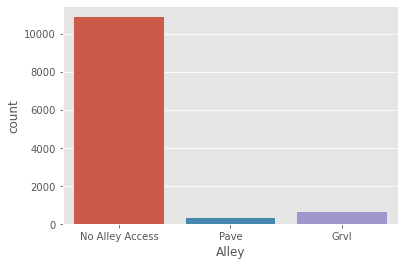

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


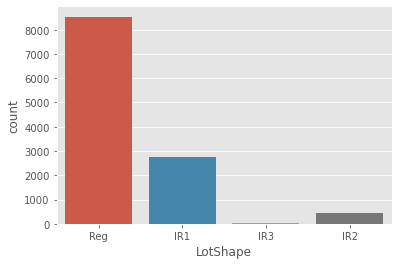

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


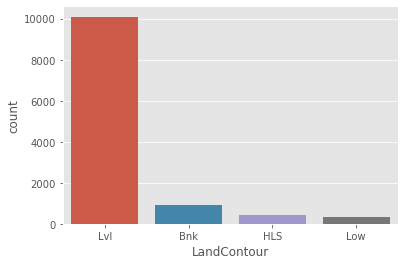

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


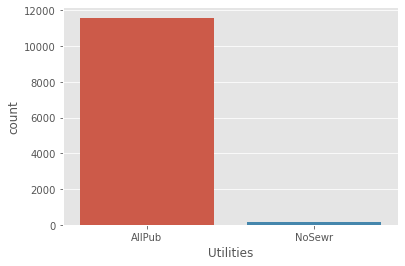

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


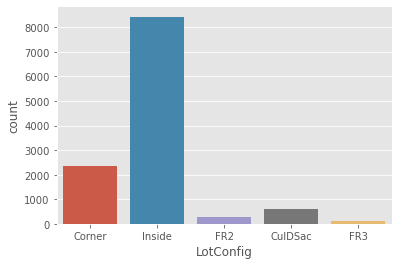

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


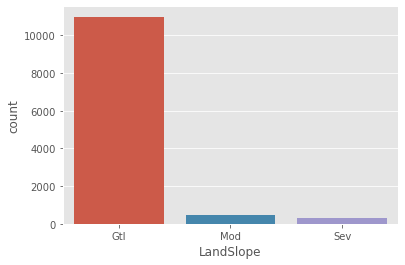

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


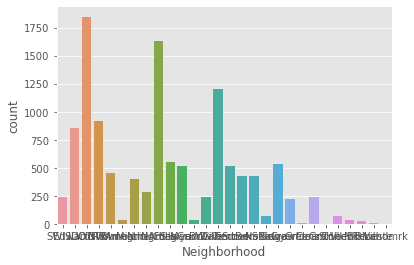

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


11766
11766


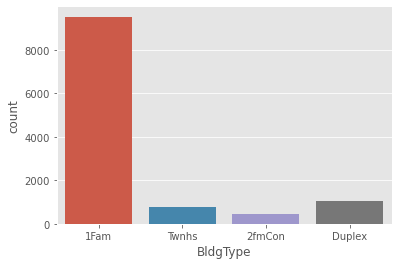

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


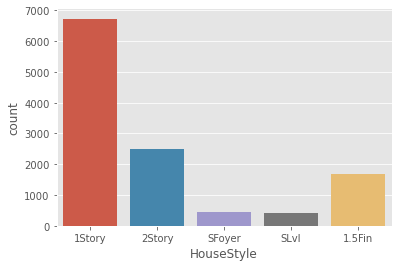

11766
11766
11766
11766
11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


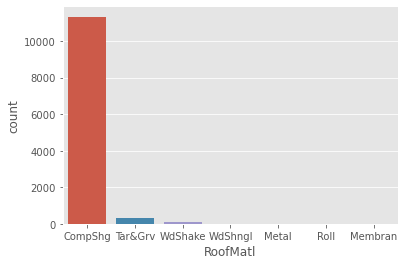

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


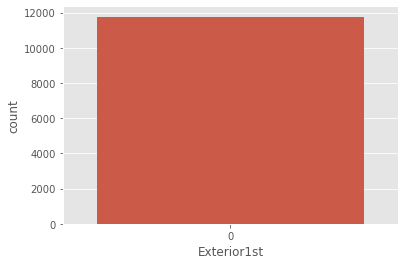

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


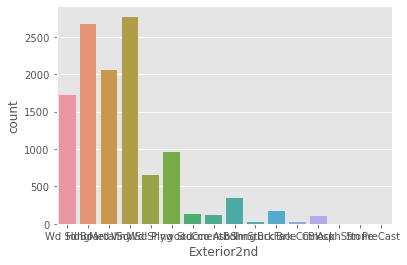

11766
11766
11766
11766
11766
11766
11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


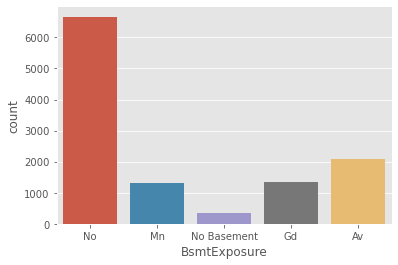

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


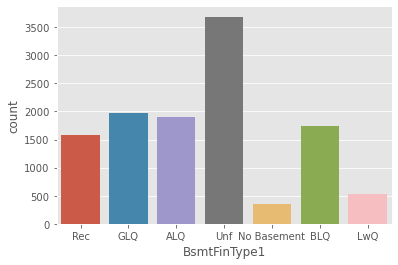

11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


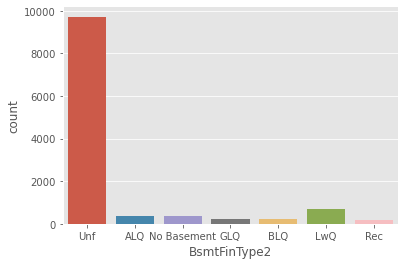

11766
11766
11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


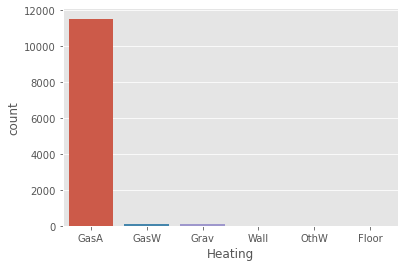

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


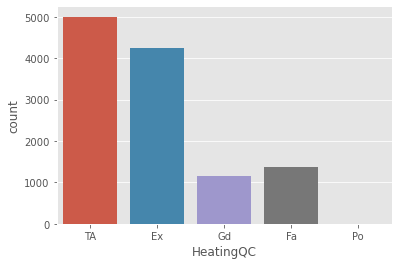

11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


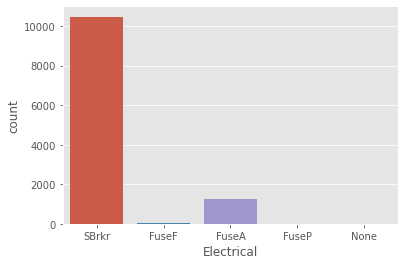

11766
11766
11766
11766
11766
11766
11766
11766
11766
11766
11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


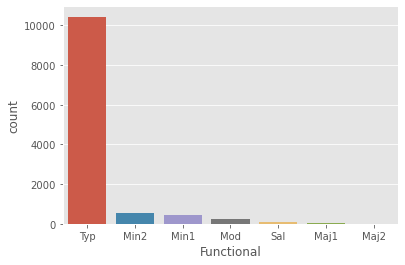

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


11766


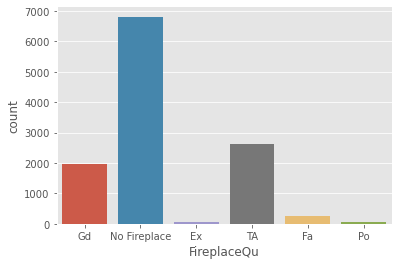

11766
11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


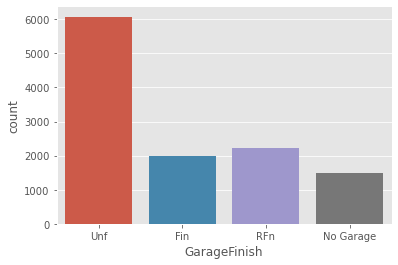

11766
11766
11766
11766
11766
11766
11766
11766
11766
11766
11766
11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


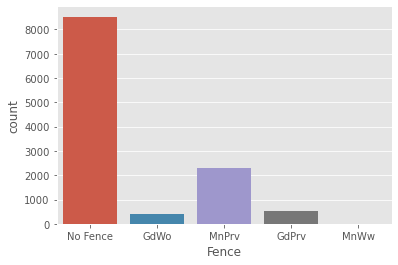

11766
11766
11766


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


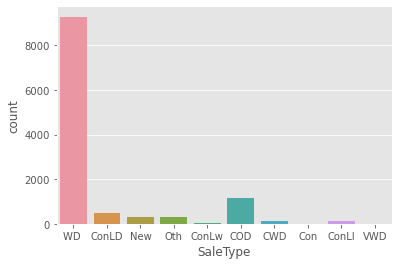

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


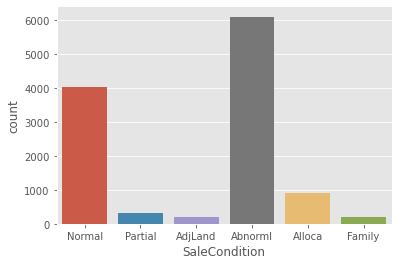

11766
11766
11766
11766
11766
11766
11766


In [58]:
# Keep the numerical data to the left and categorical data to the right.
# Visualise the proportion of each categorical labels
categorical_data=[]
housing_new =pd.DataFrame()
#print(len(housing_new))
housing_new["SalePrice"]=housing["SalePrice"]
for ele in housing.columns:
    if np.dtype(housing[ele])== "int64" or np.dtype(housing[ele])=="float64":
        housing_new[ele] = housing[ele]
        print(len(housing_new))
    else:
        categorical_data.append(ele)
        sns.countplot(housing[ele])
    plt.show()

In [59]:
for name in categorical_data:
    print(name, ': number of values', len(housing[name].value_counts()))

MSZoning : number of values 7
Alley : number of values 3
LotShape : number of values 4
LandContour : number of values 4
Utilities : number of values 2
LotConfig : number of values 5
LandSlope : number of values 3
Neighborhood : number of values 28
BldgType : number of values 4
HouseStyle : number of values 5
RoofMatl : number of values 7
Exterior1st : number of values 1
Exterior2nd : number of values 16
BsmtExposure : number of values 5
BsmtFinType1 : number of values 7
BsmtFinType2 : number of values 7
Heating : number of values 6
HeatingQC : number of values 5
Electrical : number of values 5
Functional : number of values 7
FireplaceQu : number of values 6
GarageFinish : number of values 4
Fence : number of values 5
SaleType : number of values 10
SaleCondition : number of values 6


In [60]:
for ele in categorical_data:
    housing_new[ele] = housing[ele]

In [61]:
# Get the dummies of each categorical Data.
for ele in categorical_data:
    # Converting type of columns to category
    housing_new=pd.get_dummies(housing_new, prefix="{}_".format(ele), 
                            columns=[ele], 
                            drop_first=True)
    

housing_new#=housing_new.drop(["repeat","repeat_x", "repeat_y"], axis=1)

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,SalePrice,repeat1,repeat,PID,GrLivArea,MSSubClass,LotFrontage,LotArea,Street,Condition1,...,SaleType__ConLw,SaleType__New,SaleType__Oth,SaleType__VWD,SaleType__WD,SaleCondition__AdjLand,SaleCondition__Alloca,SaleCondition__Family,SaleCondition__Normal,SaleCondition__Partial
0,126000,0,0,909176150,856,30,70.0,7890,1,0,...,0,0,0,0,1,0,0,0,1,0
1,139500,1,1,905476230,1049,120,42.0,4235,1,0,...,0,0,0,0,1,0,0,0,1,0
2,124900,2,2,911128020,1001,30,60.0,6060,1,0,...,0,0,0,0,1,0,0,0,1,0
3,114000,3,3,535377150,1039,70,80.0,8146,1,0,...,0,0,0,0,1,0,0,0,1,0
4,227000,4,4,534177230,1665,60,70.0,8400,1,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11761,121000,4362,2572,903205040,952,30,70.0,8854,1,0,...,0,0,0,0,1,0,0,0,1,0
11762,139600,4363,2573,905402060,1733,20,70.0,13680,1,0,...,0,0,0,0,1,0,0,0,1,0
11763,145000,4364,2574,909275030,2002,90,82.0,6270,1,0,...,0,0,0,0,1,0,0,0,1,0
11764,217500,4365,2575,907192040,1842,60,70.0,8826,1,0,...,0,0,0,0,1,0,0,0,1,0


# Fit the data 

--------------------------------------------------
R^2 for train set: 0.964203
R^2 for test set: 0.957323
--------------------------------------------------


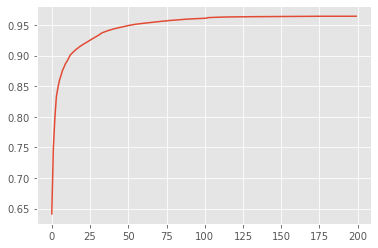

In [62]:
from sklearn.model_selection import train_test_split
from itertools import combinations
 
# Get all combinations of according to the best contributions in increasing the R^2
# The process creates a partail ording among the predictors where A rel B if A is Subset of B and R2A <=R2B
# The time complexity of this process is n* nC1=n**2 where n is the number of columns
fnlst =[]
cscores =[]
for ele in range(1,len(housing_new.columns),1):
    
    comb = combinations(housing_new.iloc[:,1:].columns.difference(fnlst), 1)

    lst=[]
    scores=[]
    
    # Print the obtained combinations
    for i in list(comb):
        ols = LinearRegression()
        X_train, X_test, y_train, y_test = train_test_split(housing_new[fnlst+list(i)], housing_new.iloc[:,0], test_size=0.5, random_state=0)
        #lst.append(list(i))
        ols.fit(X_train, y_train)
        lst.append(list(i))
        scores.append(ols.score(X_train, y_train))
    cscores.append(pd.Series(scores).max())
    fnlst =fnlst+lst[pd.Series(scores)[pd.Series(scores)==pd.Series(scores).max()].index[0]]





ols = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(housing_new[fnlst], housing_new.iloc[:,0], test_size=0.5, random_state=0)

ols.fit(X_train, y_train)
print('-'*50)

print("R^2 for train set: %f" %ols.score(X_train, y_train))
print("R^2 for test set: %f" %ols.score(X_test, y_test))

print('-'*50)



plt.plot(range(len(cscores)), cscores)